# Bayesian transfer learning with posterior

Transfer learning is the task of first training a model on a large dataset and then fine-tuning on a downstream task by initializing the network with the optimal parameters found in the first step.

Formally, we have two datasets: $D_1 = \{x_k, y_k \}_{k=1}^K$ and $D_2 = \{x_j, y_j \}_{j=1}^J$
where we let $x \in R^d$ and $y \in R$.
Typically $K>>J$.
We also have a parameterized model $f_{\theta}(x)$ based on some model parameters $\theta$, and assume that the likelihood function is gaussian.

Common examples for transfer learning is when $x$ is an image and $y$ is a class label.
Another example is in natural language processing when also the task is different. In step 1: $x$ is a sequence of words, $y$ is a padded version of the word. 
In step 2 it is usually a classification task for $y$ in the same language.

We will focus on the task when x is a d-dimensional vector, and y is a scalar output.
It should, however, be possible to generalize this.

## Standard transfer learning
Standard transfer learning is done in two steps: 

- step 1: Find the MLE-estimate of  $D_1$ and get optimal parameters:

$$ \theta_1^* = argmax_{\theta} \prod_{\{x_k, y_k\} \in D_1} N(y_k ; f(x_k), \sigma)$$ 

- Step 2: Find the MLE-estimate of $D_2$, and initialize the parameters in the previously found optimal parameters $\theta_1^*$.

If we had an optimization technique that guaranteed us to end up in a global optimum, this two-step procedure would not make sense.
However, neural networks do not end up in good global optimums, and the common understanding of transfer learning is that initializing the model with some parameters from a different task is regularizing 

## Bayesian transfer learning
We can formulate transfer learning in a more probabilistic way.
That is, by first learning a posterior distribution of the parameters given the first dataset, and then learning the posterior of the second dataset given the second dataset plus the posterior found in the first step:

- Step 1: Find the posterior distribution $P(\theta | D_1)$ using dataset 1.
- Step 2: Find the posterior distribution given dataset $D_2$ and the posterior found in step 1:

$$P(\theta | D_1, D_2) \sim P(D_2 | \theta) * P(\theta | D_1) $$

If we have the exact posterior of the first dataset $ P(\theta | D_1)$ this is straight forward.
However, we do not, and $ P(\theta | D_1)$ is usually found using mcmc or similar.

An approach explored in Kirkpatrick (2017) is to model the posterior as gaussian around the posterior mode, and shows multiple improvements.
The method is particularly interesting as this gaussian approximation can be seen as a l2-regularization towards the parameters found in step 1.

However, it is unrealistic to believe that the posterior is gaussian around the posterior mode.
Multiple papers have found the posterior of neural networks to be highly complex and multi-modal (see e.g. cyclical mcmc paper).
At the same time, we need some approximation.
The approximation should also be differentiable with respect to the parameters as we then can use gradient based methods in step 2.

## Mixture gaussian as approximation to $ P(\theta | D_1)$
Given that we have solved step 1 with an mcmc algorithm we can obtain $L$ samples from the posterior $\theta_1, ..., \theta_L$.
Let us approximate this posterior as a mixture gaussian over all these points:

$$ 
P(\theta | D_1) \approx \frac{1}{L} \sum_{l=1}^L N(\theta ; \theta_l, \sigma)
$$
where $\sigma>0$ is a hyperparameter.
We can use this approximation as our prior when solving step 2, using $\sigma$ as a hyperparameter we can set depending how similar the two tasks are.

The advantage of this approximation over the Kirkpatrick (2017) approximation is that is allows for non-gaussian distributions.

If we focus on finding the posterior mode in step 2 this problem can now be seen as standard MLE with a regularization towards a weighted sum of multiple gaussian kernels:

$$
P(\theta | D_1, D_2) 
\sim P(D_2 | \theta) P(\theta | D_1)
\approx P(D_2 | \theta) \sum_{l=1}^L N(\theta ; \theta_l, \sigma)
$$

If we want to find the posterior mode we can maximize the log probability:
$$
lnP(\theta | D_1, D_2) \approx logP(D_2 | \theta) + log( \frac{1}{L \sqrt{2 \pi \sigma^2}} \sum_{l=1}^L exp(-\frac{1}{2 \sigma} ||\theta - \theta_l||^2)))
$$
where $||x||$ is the l2 norm applied on each element of $x$ and then summed.

It should work better than L2-regularization because we have a better approximation to the posterior of step 1.
In the special case of only one set of parameters $L=1$ where this is in the posterior mode, it is equvialent to the Kirkpatrick (2017) model.


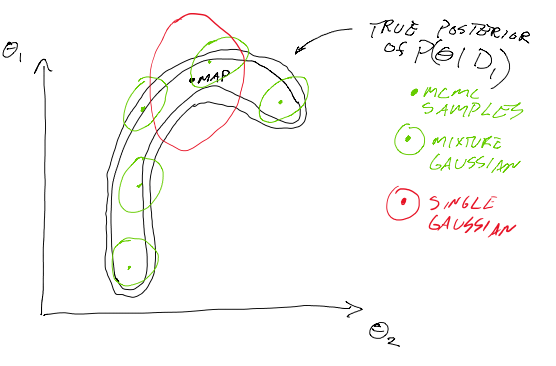

In [1]:
from IPython.display import Image
Image(filename="assets/posterior-approx.png")

## Implementation
The implementation of this framework is straight forward. The main difference is that we need to collect a set of samples from the posterior in step 1: We can do this with stochastic MCMC starting in the already found mode. The longer we can run the chain the better, but intuitively each step should give us a better approximation.

In step 2 we need to add the posterior of step 1 as prior. This is straight forward as it is just a sum of gaussians.

The method could be tested on a variety of tasks and we can directly compare them with existing transfer learning techniques using only MAP estimates of the first step. For example:

- Vision: Step1 train with imagenet, step2 on a smaller classification task.
- Text: We use any of the SOTA bert pretrained models and continue to run them with stochastic noise from their current parameters. Then we use those samples to estimate a different task.

Expected behaviour: the estimated likelihood should increase as we increase the number of mcmc samples $L$ in step 1.

### Related papers
- Kirkpatrick, J., Pascanu, R., Rabinowitz, N., Veness, J., Desjardins, G., Rusu, A. A., … Hadsell, R. (2017). Overcoming catastrophic forgetting in neural networks. Proceedings of the National Academy of Sciences of the United States of America, 114(13), 3521–3526. https://doi.org/10.1073/pnas.1611835114
- Kernelized Bayesian Transfer Learning https://users.ics.aalto.fi/gonen/files/gonen_aaai14_paper.pdf
- Informative Gaussian Scale Mixture Priors for Bayesian Neural Networks
 https://arxiv.org/abs/2002.10243
 - Stackexchange discussion showing the "regularizer" with a prior mixture gaussian: https://stats.stackexchange.com/questions/360487/gaussian-mixture-as-a-prior-of-gaussian/360500